In [1]:
# ==========================================================
# FRESH PREDICTION SCRIPT
# ==========================================================

import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
import os
from google.colab import drive

# ==============================
# 1. Mount Drive & Define Paths
# ==============================
try:
    drive.mount('/content/drive')
except:
    print("Drive already mounted.")

# --- This MUST match the path you saved to ---
load_dir = "/content/drive/MyDrive/financial_model"

# --- This is the path to your NEW company file ---
new_company_file = "/content/XYZ_Industries_2021_2025.xlsx"

# ==============================
# 2. Define Constants
# (Must match your training script)
# ==============================
SEQ_LEN = 16

TARGETS = [
    "Risk_Score",
    "Growth_Score",
    "Profitability_Score",
    "Stability_Score",
    "Sector_Score",
    "Overall_Score",
]

MACRO_FEATURES = ["GST", "CorpTax%", "Inflation%", "RepoRate%", "USDINR_Close"]
SEQ_FEATURES = TARGETS + MACRO_FEATURES

# ==============================
# 3. Load Model & Artifacts
# ==============================
try:
    # Load Keras Model
    model = tf.keras.models.load_model(os.path.join(load_dir, "bilstm_model.keras"))

    # Load Scalers
    scaler_X = joblib.load(os.path.join(load_dir, "scaler_X.pkl"))
    scaler_y = joblib.load(os.path.join(load_dir, "scaler_y.pkl"))

    # Load the critical training DF for context
    df_train = pd.read_pickle(os.path.join(load_dir, "scaled_training_df.pkl"))

    print("✅ Model and all artifacts loaded successfully!")

except Exception as e:
    print(f"❌ Error loading artifacts: {e}")
    print("Please ensure all files (model, scalers, and df) are in the correct Drive folder.")

# ==========================================================
# 4. Prediction Function
# (Copied EXACTLY from your training script's Section 15)
# ==========================================================
def predict_new_companies(excel_path, model, scaler_X, scaler_y, df_train, SEQ_FEATURES, TARGETS, SEQ_LEN=16):
    """
    Predict next-quarter scores for new companies using their past 16 quarters data.
    """
    # Load new company data
    new_df = pd.read_excel(excel_path)
    print(f"\n📂 New file loaded: {new_df.shape}")
    print("Columns:", new_df.columns.tolist())

    company_col = "Company"
    date_col = "FiscalDate"

    # Ensure same features exist
    for col in SEQ_FEATURES:
        if col not in new_df.columns:
            raise ValueError(f"Column '{col}' missing in new dataset.")

    # Handle missing values and outliers similarly to training
    # NOTE: This uses df_train (the *scaled* training df) for clipping boundaries,
    # which matches your original script's logic.
    for col in SEQ_FEATURES:
        new_df[col] = new_df[col].ffill().bfill()
        new_df[col] = np.clip(
            new_df[col],
            df_train[col].quantile(0.01),  # Boundary from scaled training data
            df_train[col].quantile(0.99)   # Boundary from scaled training data
        )

    # Scale using *loaded* training scalers
    new_df[SEQ_FEATURES] = scaler_X.transform(new_df[SEQ_FEATURES])

    # Assign a new company encoding (dummy ID for new companies)
    new_df["Company_Encoded"] = 0

    predictions = {}

    # Iterate through unique companies in new file
    for comp in new_df[company_col].unique():
        comp_data = new_df[new_df[company_col] == comp].sort_values(by=date_col)

        if len(comp_data) < SEQ_LEN:
            print(f"⚠️ Not enough data for {comp} (need {SEQ_LEN} quarters). Skipping.")
            continue

        # Get the last sequence of 16 quarters
        last_seq = comp_data[SEQ_FEATURES].values[-SEQ_LEN:]
        last_seq = np.expand_dims(last_seq, axis=0) # Add batch dimension

        # Format company ID input
        company_input = np.array([[int(comp_data["Company_Encoded"].iloc[0])]], dtype=np.int32)

        # Predict (output is on scaler_y scale)
        pred_scaled = model.predict([last_seq, company_input], verbose=0)

        # Inverse transform to scaler_X scale
        pred = scaler_y.inverse_transform(pred_scaled)[0]

        # Scale 0–100 based on *original training data's* scaled min/max
        scaled_pred = {}
        for i, col in enumerate(TARGETS):
            # This is the critical step that was failing:
            # We MUST use the min/max from the loaded df_train
            col_min, col_max = df_train[col].min(), df_train[col].max()

            # This formula rescales from the 'scaler_X' range to 0-100
            scaled_val = 100 * (pred[i] - col_min) / (col_max - col_min)
            scaled_pred[col] = round(float(scaled_val), 2)

        predictions[comp] = scaled_pred

    return predictions

# ==============================
# 5. Run Prediction
# ==============================
if 'model' in locals():
    new_predictions = predict_new_companies(
        excel_path=new_company_file,
        model=model,
        scaler_X=scaler_X,
        scaler_y=scaler_y,
        df_train=df_train,
        SEQ_FEATURES=SEQ_FEATURES,
        TARGETS=TARGETS,
        SEQ_LEN=SEQ_LEN
    )

    print("\n📊 Predictions for New Companies (0–100 scale):")
    for comp, preds in new_predictions.items():
        print(f"\n{comp}:")
        for k, v in preds.items():
            print(f"  {k}: {v}")
else:
    print("❌ Model not loaded. Cannot run predictions.")

Mounted at /content/drive
✅ Model and all artifacts loaded successfully!

📂 New file loaded: (16, 24)
Columns: ['FiscalDate', 'Company', 'Sector', 'Revenue', 'Expenses', 'EBITDA', 'Operating Margin %', 'Depreciation', 'Interest', 'PBT', 'Tax', 'Net Profit', 'EPS', 'GST', 'CorpTax%', 'Inflation%', 'RepoRate%', 'USDINR_Close', 'Risk_Score', 'Growth_Score', 'Profitability_Score', 'Stability_Score', 'Sector_Score', 'Overall_Score']

📊 Predictions for New Companies (0–100 scale):

XYZ Industries Ltd:
  Risk_Score: 9.85
  Growth_Score: 49.01
  Profitability_Score: 53.81
  Stability_Score: 58.43
  Sector_Score: 45.81
  Overall_Score: 35.32



📊 PCA + Agglomerative Clustering (Average Linkage) Results:
                                  Company  Predicted_Risk_Score  Cluster Risk_Level
                  lic-housing-finance-ltd                  3.46        2        Low
                  gic-housing-finance-ltd                  3.78        2        Low
                  pnb-housing-finance-ltd                  3.84        2        Low
                   repco-home-finance-ltd                  3.91        2        Low
                   adani-green-energy-ltd                  4.29        2        Low
                        bank-of-india-ltd                  4.38        2        Low
                 punjab-national-bank-ltd                  4.41        2        Low
                             yes-bank-ltd                  4.42        2        Low
                     sundaram-finance-ltd                  4.43        2        Low
                         federal-bank-ltd                  4.58        2        Low
               

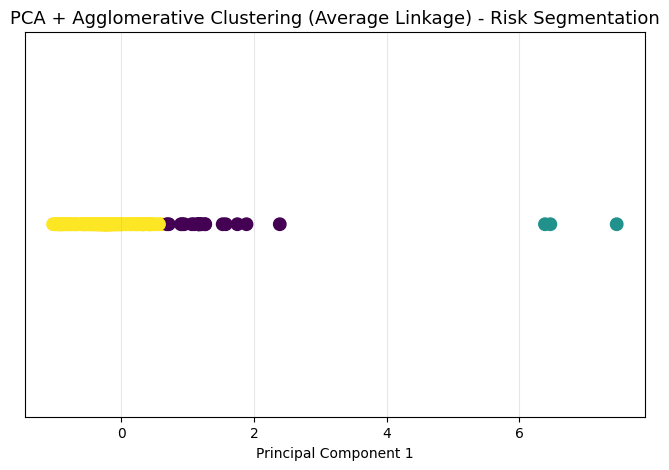


✅ Clustering results saved to:
/content/drive/MyDrive/financial_model/risk_clustering_results.csv


In [2]:
# ==========================================================
# 6. Risk Assessment using Agglomerative Clustering (Average Linkage)
# ==========================================================
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# --- Path to previously saved all-company risk scores ---
risk_csv_path = "/content/drive/MyDrive/financial_model/all_company_risk_scores.csv"
all_risks = pd.read_csv(risk_csv_path)

# --- Add the new company's predicted risk score ---
# Extract the Risk_Score directly from the latest prediction
new_company_name = list(new_predictions.keys())[0]
new_risk_score = new_predictions[new_company_name]["Risk_Score"]

new_entry = pd.DataFrame([{
    "Company": new_company_name,
    "Predicted_Risk_Score": new_risk_score
}])

# Combine with existing company risk scores
all_risks = pd.concat([all_risks, new_entry], ignore_index=True)

# ==========================================================
# Scale & Apply PCA (for visualization and noise reduction)
# ==========================================================
scaler = StandardScaler()
scaled_data = scaler.fit_transform(all_risks[["Predicted_Risk_Score"]])

pca = PCA(n_components=1)
pca_data = pca.fit_transform(scaled_data)

# ==========================================================
# Perform Agglomerative Clustering (Average Linkage, 3 clusters)
# ==========================================================
clustering = AgglomerativeClustering(n_clusters=3, linkage='average')
clusters = clustering.fit_predict(pca_data)

all_risks["Cluster"] = clusters

# ==========================================================
# Label Clusters as Low / Medium / High Risk
# ==========================================================
cluster_means = all_risks.groupby("Cluster")["Predicted_Risk_Score"].mean().sort_values()
risk_levels = {cluster: level for cluster, level in zip(cluster_means.index, ["Low", "Medium", "High"])}
all_risks["Risk_Level"] = all_risks["Cluster"].map(risk_levels)

# ==========================================================
# Display Results
# ==========================================================
print("\n📊 PCA + Agglomerative Clustering (Average Linkage) Results:")
print(all_risks.sort_values(by="Predicted_Risk_Score").to_string(index=False))

# Highlight the new company’s cluster
new_row = all_risks[all_risks["Company"] == new_company_name].iloc[0]
print(f"\n🔍 Risk Assessment for {new_company_name}:")
print(f"   ➤ Predicted Risk Score: {new_row['Predicted_Risk_Score']}")
print(f"   ➤ Assigned Risk Level: {new_row['Risk_Level']}")

# ==========================================================
# Optional: Visualize the clustering in PCA space
# ==========================================================
plt.figure(figsize=(8, 5))
plt.scatter(pca_data[:, 0], [0]*len(pca_data), c=clusters, cmap='viridis', s=80)
plt.title("PCA + Agglomerative Clustering (Average Linkage) - Risk Segmentation", fontsize=13)
plt.xlabel("Principal Component 1")
plt.yticks([])
plt.grid(alpha=0.3)
plt.show()

# ==========================================================
# Save Clustering Output
# ==========================================================
output_path = "/content/drive/MyDrive/financial_model/risk_clustering_results.csv"
all_risks.to_csv(output_path, index=False)
print(f"\n✅ Clustering results saved to:\n{output_path}")
